### Download CIFAR10 dataset

In [1]:
from urllib.request import urlretrieve
from urllib.parse import urlparse
import os

cifar10_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
cifar10_archive_file = os.path.basename(urlparse(cifar10_url).path)

urlretrieve(cifar10_url, cifar10_archive_file)

('cifar-10-python.tar.gz', <http.client.HTTPMessage at 0x1ac796fb320>)

### Extract archive file

In [0]:
import tarfile

def extract_archive_file(archive_file):
  with tarfile.open(archive_file) as file:
    file.extractall()
    
extract_archive_file(cifar10_archive_file)

### Load data from archive file

In [128]:
import numpy as np
import os

cifar_path = "cifar-10-batches-py"

def load_data(cifar_path):
  data = load_batches(cifar_path)
  test_data = load_test_batch(cifar_path)
  return data, test_data 

def unpickle(file):
  import pickle
  with open(file, 'rb') as fo:
      dict = pickle.load(fo, encoding='bytes')
  return dict

def load_batches(cifar_path):
  batch_names = [ "data_batch_{}".format(i) for i in range(1, 6) ]
  data_batches = [ load_batch(cifar_path, batch_name) for batch_name in batch_names ]
  data = [ data for (data, label) in data_batches ]
  labels = [ label for (data, label) in data_batches ]
  return np.concatenate(data), np.concatenate(labels)

def load_test_batch(cifar_path):
  return load_batch(cifar_path, "test_batch");

def load_batch(cifar_path, batch_name):
  data_batch = unpickle(os.path.join(cifar_path, batch_name))
  return data_batch[b'data'], data_batch[b'labels']

(X_train, y_train), (X_test, y_test) = load_data(cifar_path)


### Reshape samples

Make 32x32x3 images from 3072 long feature vecor, to be able to show it, feed it into HOG and Resnet50

In [129]:
def reshape(image):
  red_channel = image[0:1024].reshape(32, 32)
  green_channel = image[1024:2048].reshape(32, 32)
  blue_cannel = image[2048:3072].reshape(32, 32)
  return np.dstack((red_channel, green_channel, blue_cannel))

In [130]:
X_train_reshaped = np.asarray([reshape(x) for x in X_train ])
X_test_reshaped = np.asarray([reshape(x) for x in X_test ])

### Show random images from each category

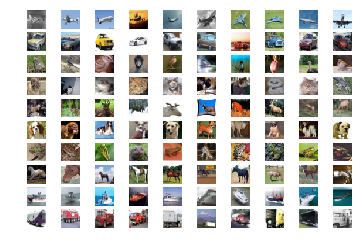

In [137]:
import matplotlib.pyplot as plt

number_of_classes = 10
number_of_examples = 10

def get_random_subsets_by_class(X, y, number_of_classes, number_of_examples):
  data_by_class = [ X[y == class_number] for class_number in range(number_of_classes) ]
  return [ get_random_subset(data, number_of_examples) for data in data_by_class ]
  
def get_random_subset(data, number_of_examples):
  indices = np.random.choice(range(data.shape[0]), number_of_examples)
  return data[indices]

random_subset_by_class = get_random_subsets_by_class(
        X_train_reshaped,
        y_train,
        number_of_classes,
        number_of_examples)

fig, axes = plt.subplots(nrows=number_of_classes, ncols=number_of_examples)
for i in range(number_of_examples):
    for j in range(number_of_classes):
        axes[i, j].imshow(random_subset_by_class[i][j])
        axes[i, j].set_axis_off()

### Benchmark using hog feature extractor

#### Extract hog features

In [138]:
from skimage.feature import hog
from skimage import color
from matplotlib.pyplot import imshow

def get_hog(image):
  grey_image = color.rgb2gray(image)
  return hog(grey_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', feature_vector=True)

In [142]:
X_train_hog = np.asarray([ get_hog(x) for x in X_train_reshaped ])
X_test_hog = np.asarray([ get_hog(x) for x in X_test_reshaped ])

In [143]:
X_train_hog.shape

(50000, 324)

#### Show features with reduced dimensionality

In [145]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X_hog_pca_10 = PCA(n_components=10).fit_transform(X_train_features[0:10000])
X_hog_tsne = TSNE(n_components=2).fit_transform(X_hog_pca_10)

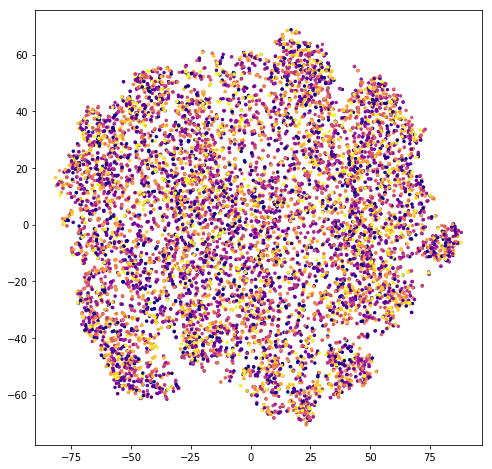

In [148]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(X_hog_tsne[:, 0], X_hog_tsne[:, 1], c=y_train[0:10000], s=6, cmap='plasma')

#### Find best C parameter for Linear SVM model

Use only 5000 samples to make the process quicker

In [156]:
np.logspace(-4, 0, 13)

array([1.00000000e-04, 2.15443469e-04, 4.64158883e-04, 1.00000000e-03,
       2.15443469e-03, 4.64158883e-03, 1.00000000e-02, 2.15443469e-02,
       4.64158883e-02, 1.00000000e-01, 2.15443469e-01, 4.64158883e-01,
       1.00000000e+00])

In [158]:
parameters = {'C': np.logspace(-4, 0, 13)}

svc_hog_model = svm.LinearSVC()
grid_search = GridSearchCV(svc_hog_model, parameters, cv=3, n_jobs=8)
grid_search.fit(X_train_hog[0:5000], y_train[0:5000]) 

GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'C': array([1.00000e-04, 2.15443e-04, 4.64159e-04, 1.00000e-03, 2.15443e-03,
       4.64159e-03, 1.00000e-02, 2.15443e-02, 4.64159e-02, 1.00000e-01,
       2.15443e-01, 4.64159e-01, 1.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [159]:
print(grid_search.best_estimator_)
print(grid_search.best_score_)

LinearSVC(C=0.00046415888336127773, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)
0.4382


Best C=0.00046415888336127773

#### Train linear SVM model on the features

In [161]:
from sklearn import svm
from sklearn.metrics import accuracy_score

svc_model = svm.LinearSVC(C=0.0004642)
svc_model.fit(X_train_hog, y_train) 

y_pred = svc_model.predict(X_test_hog)
accuracy_score(y_test, y_pred)

0.482

The benchmark above gave 0.482 accuracy on the test set.

### Extract features using ResNet50

Prepare data to be fed into resnet: resize it to the minimal input size of 200x200 pixels

In [87]:
import scipy

def resize_to_200_200(img):
  return scipy.misc.imresize(img, (200, 200, 3))

X_train_200 = np.asarray([resize_to_200_200(x) for x in X_train_reshaped ])
X_test_200 = np.asarray([resize_to_200_200(x) for x in X_test_reshaped ])


c:\users\pawel\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


#### Initialize ResNet50 model

Use keras implementation without the last layer

In [88]:
from keras import applications

resnet50 =  applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

#### Extract features

In [150]:
X_train_features = resnet50.predict(X_train_200)
X_test_features = resnet50.predict(X_test_200)

#### Save features to files

In [42]:
import pickle
with open('C:\\Users\\pawel\\Documents\\cifar\\x_train_features_resnet.pickle', 'wb') as file:
  pickle.dump(X_train_features, file)

with open('C:\\Users\\pawel\\Documents\\cifar\\y_train_resnet.pickle', 'wb') as file:
  pickle.dump(y_train, file)
  
with open('C:\\Users\\pawel\\Documents\\cifar\\x_test_features_resnet.pickle', 'wb') as file:
  pickle.dump(X_test_features, file)

with open('C:\\Users\\pawel\\Documents\\cifar\\y_test_resnet.pickle', 'wb') as file:
  pickle.dump(y_test, file)

#### Load features from files

In [1]:
import pickle
with open('x_train_features_resnet.pickle', 'rb') as file:
  X_train_features = pickle.load(file)

with open('y_train_resnet.pickle', 'rb') as file:
  y_train = pickle.load(file)

with open('x_test_features_resnet.pickle', 'rb') as file:
  X_test_features = pickle.load(file)

with open('y_test_resnet.pickle', 'rb') as file:
  y_test = pickle.load(file)

### Visualize features using PCA and t-SNE

Use PCA only for 20000 samples

In [172]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_2 = pca.fit_transform(X_train_features[0:20000])

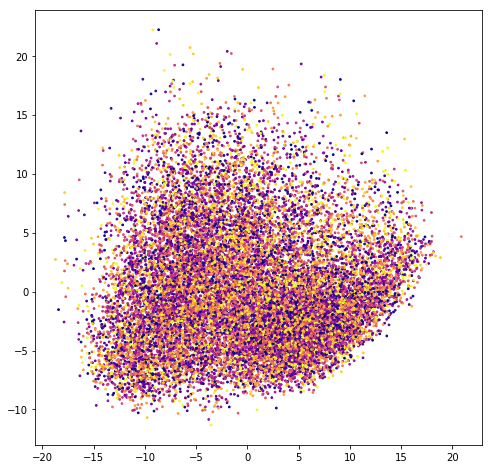

In [173]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(pca_2[:, 0], pca_2[:, 1], c=y_train[0:20000], s=3, cmap='plasma')

The boundaries between classes are not really clear, let's use t-SNE

t-SNE won't work efficiently on 50000 samples each with 2048 features, so use PCA first to have 50 features first

In [174]:
pca = PCA(n_components=50)
pca_50 = pca.fit_transform(X_train_features[0:20000])

In [ ]:
from sklearn.manifold import TSNE
import time

start_time = time.time()
X_tsne = TSNE(n_components=2).fit_transform(pca_50)
print("--- %s seconds ---" % (time.time() - start_time))

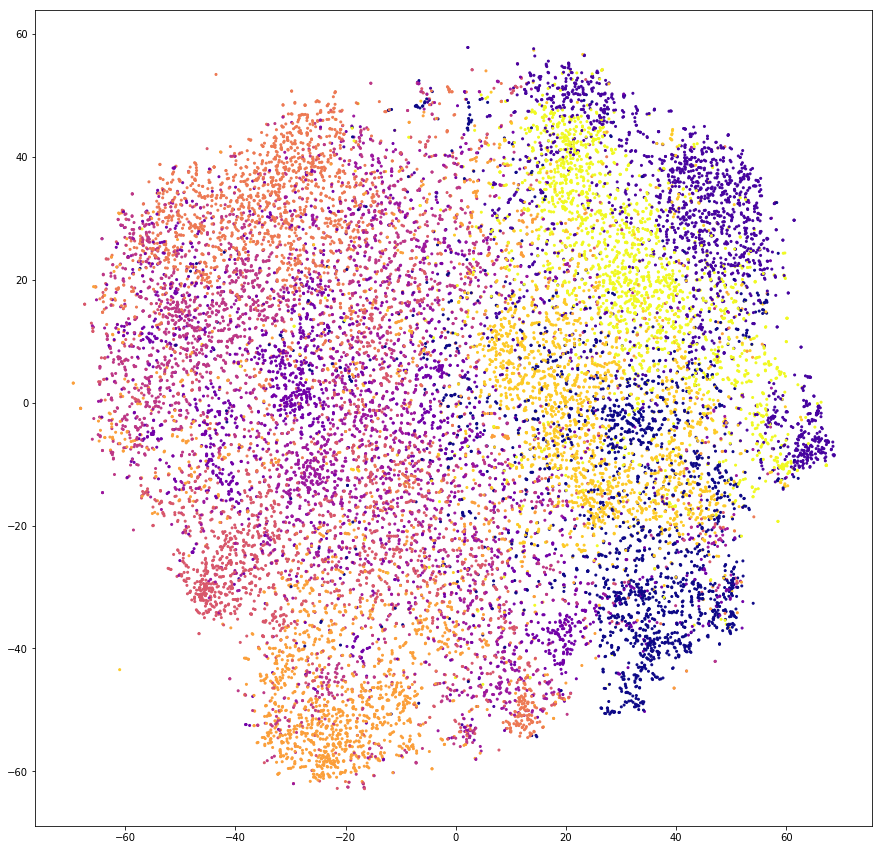

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train[0:20000], s=4, cmap='plasma')

### Train SVM classifier on the features

#### Find hyper parameters for Linear SVM

Find best C parameter for Linear SVC model

Notes: 
- the ``np.logspace(-3, -2, 13)`` range is already narrowed down after previous, more broad searches.  
- search on part of the samples (10000), and using 8 cores to speed up the process

In [33]:
parameters = {'C': np.logspace(-3, -2, 13)}

svc_model = svm.LinearSVC()
grid_search = GridSearchCV(svc_model, parameters, cv=3, n_jobs=8)
grid_search.fit(X_train_features[0:10000], y_train[0:10000]) 


GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'C': array([0.001  , 0.00121, 0.00147, 0.00178, 0.00215, 0.00261, 0.00316,
       0.00383, 0.00464, 0.00562, 0.00681, 0.00825, 0.01   ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [34]:
print(grid_search.best_estimator_)
print(grid_search.best_score_)

LinearSVC(C=0.001211527658628589, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)
0.8297


Best C = 0.0031622776601683794

#### Find hyper parameters for SVM with RBF kernel

Find best C and gamma parameters for SVM classifier with RBF kerne using GridSearchCV. This is done for a small subset of samples and run in parallel.

Notes: 
- the ``np.logspace(0, 1, 6)`` and ``np.logspace(-4, -2, 7)`` ranges are already narrowed down after previous, more broad searches,
- search on part of the samples (10000), and using 8 cores to speed up the process

In [27]:
np.logspace(-3, -2, 13)

array([0.001     , 0.00121153, 0.0014678 , 0.00177828, 0.00215443,
       0.00261016, 0.00316228, 0.00383119, 0.00464159, 0.00562341,
       0.00681292, 0.00825404, 0.01      ])

In [111]:
from sklearn import svm
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

parameters = {'C': np.logspace(0, 2, 6), 'gamma': np.logspace(-4, -2, 7)}

svc_model = svm.SVC()
grid_search = GridSearchCV(svc_model, parameters, cv=3, n_jobs=4)
grid_search.fit(X_train_features[0:5000], y_train[0:5000]) 


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'C': array([  1.     ,   2.51189,   6.30957,  15.84893,  39.81072, 100.     ]), 'gamma': array([0.0001 , 0.00022, 0.00046, 0.001  , 0.00215, 0.00464, 0.01   ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [113]:
print(grid_search.best_estimator_)
print(grid_search.best_score_)

SVC(C=6.309573444801933, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.7926


In [ ]:
Best found C=6.309573444801933, gamma = 0.001

#### Train linear model

Train linear model with C = 0.0031622776601683794 for whole training set

In [47]:
svc_model = svm.LinearSVC(C = 0.0031622776601683794)
svc_model.fit(X_train_features, y_train, y_dev) 

LinearSVC(C=0.0031622776601683794, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)

In [40]:
y_pred = svc_model.predict(X_test_features)
accuracy_score(y_test, y_pred)

0.864

Best score: 0.864

#### Train model with RBF kernel

Train SVM with RBF kernel with C = 6.309573444801933 and gamma = 0.001 for whole training set

In [114]:
svc_model = svm.SVC(C=6.309573444801933, gamma=0.001)
svc_model.fit(X_train_features, y_train)

--- 1421.3046476840973 seconds ---


In [115]:
y_pred = svc_model.predict(X_test_features)
accuracy_score(y_test, y_pred)

0.8703

Best score: 0.8703